**Burbank Final Modelling**
<br/>Read in the 2017, 2018 and 2019 Burbank csv files.
<br/>Perform final feature engineering and hyperparameter optimization.
<br/>Run a final logistic regression model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# increase display size to enable viewing of all data columns

pd.options.display.max_columns = 40

Initial models run both with and without the destination airports showed very similar results, so we'll start with the airports in and let further analysis (e.g. lasso gregression / PCA) dictate what's included.

In [4]:
# read in the 2017 burbank csv

burbank2017_df = pd.read_csv('burbank2017.csv', index_col=0)
burbank2017_df

,DayOfWeek,CRSDepTime,DepDelay,Cancelled,Distance,CRSArrTime,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,B6,OO,UA,WN,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed
0,6,700,8.0,0,937,930,7.38,0.0,0.0,69.5,6.49,0.0,0.0,64.0,1,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,6,1730,-10.0,0,937,1958,7.38,0.0,0.0,69.5,6.49,0.0,0.0,64.0,1,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,6,1215,-3.0,0,937,1443,7.38,0.0,0.0,69.5,6.49,0.0,0.0,64.0,1,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,7,700,-3.0,0,937,930,7.38,0.0,0.0,71.5,4.92,0.0,0.0,62.0,2,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,7,1730,-9.0,0,937,1958,7.38,0.0,0.0,71.5,4.92,0.0,0.0,62.0,2,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25100,2,708,-2.0,0,326,833,6.71,0.0,0.0,67.5,15.66,0.0,0.0,64.0,19,9,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
25101,2,2015,-15.0,0,326,2141,6.71,0.0,0.0,67.5,15.66,0.0,0.0,64.0,19,9,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
25102,2,700,-9.0,0,850,1029,6.71,0.0,0.0,67.5,14.09,0.0,0.0,72.0,19,9,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
25103,2,1220,-6.0,0,326,1339,10.51,0.0,0.0,77.5,7.61,0.0,0.0,76.0,5,9,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [5]:
# check how many flights there are by each airline

print('B6: ' + str(burbank2017_df['B6'].sum()))
print('OO: ' + str(burbank2017_df['OO'].sum()))
print('UA: ' + str(burbank2017_df['UA'].sum()))
print('WN: ' + str(burbank2017_df['WN'].sum()))

B6: 360
OO: 4724
UA: 699
WN: 18116


In [6]:
# check how many flights have delays greater than one hour

burbank2017_df['DepDelay'][(burbank2017_df['DepDelay'] > 60)].count()

1355

In [7]:
# delete outliers (i.e. rows where the departure delays are greater than one hour)
# remove the Cancelled and DepDelay columns
# remove airline because totals are imbalanced, placing too much importance on WN
# remove CRSArrTime because most of the flights are in a local region, so arrivel and departure time are closely related

burbankdrop2017 = burbank2017_df['DepDelay'][(burbank2017_df['DepDelay'] > 60)].index
burbank2017_df.drop(burbankdrop2017, inplace=True)

burbank2017_df.to_csv('burbank2017final.csv')

burbank2017_df.drop(['Cancelled',
                     'DepDelay',
                     'CRSArrTime',
                     'B6',
                     'OO',
                     'UA',
                     'WN'], axis=1, inplace=True)
burbank2017_df

,DayOfWeek,CRSDepTime,Distance,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed
0,6,700,937,7.38,0.0,0.0,69.5,6.49,0.0,0.0,64.0,1,7,0,0,0,0,0,0,1,0,0,0,0,1
1,6,1730,937,7.38,0.0,0.0,69.5,6.49,0.0,0.0,64.0,1,7,0,0,0,0,0,0,1,0,0,0,0,1
2,6,1215,937,7.38,0.0,0.0,69.5,6.49,0.0,0.0,64.0,1,7,0,0,0,0,0,0,1,0,0,0,0,1
3,7,700,937,7.38,0.0,0.0,71.5,4.92,0.0,0.0,62.0,2,7,0,0,0,0,0,0,1,0,0,0,0,1
4,7,1730,937,7.38,0.0,0.0,71.5,4.92,0.0,0.0,62.0,2,7,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25100,2,708,326,6.71,0.0,0.0,67.5,15.66,0.0,0.0,64.0,19,9,0,0,0,0,0,0,0,1,0,0,0,1
25101,2,2015,326,6.71,0.0,0.0,67.5,15.66,0.0,0.0,64.0,19,9,0,0,0,0,0,0,0,1,0,0,0,0
25102,2,700,850,6.71,0.0,0.0,67.5,14.09,0.0,0.0,72.0,19,9,1,0,0,0,0,0,0,0,0,0,0,0
25103,2,1220,326,10.51,0.0,0.0,77.5,7.61,0.0,0.0,76.0,5,9,0,0,0,0,0,0,0,1,0,0,0,0


In [8]:
# read in the 2018 burbank csv

burbank2018_df = pd.read_csv('burbank2018.csv', index_col=0)
burbank2018_df

,DayOfWeek,CRSDepTime,DepDelay,Cancelled,Distance,CRSArrTime,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,B6,OO,UA,WN,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed
0,5,2030,-16.0,0,326,2200,6.93,0.0,0.0,74.0,15.21,0.0,0.0,62.0,31,8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5,700,21.0,0,326,826,6.93,0.0,0.0,74.0,15.21,0.0,0.0,62.0,31,8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,5,715,-2.0,0,850,1035,6.93,0.0,0.0,74.0,9.40,0.0,0.0,76.0,31,8,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,4,2030,-6.0,0,326,2200,7.38,0.0,0.0,75.5,11.18,0.0,0.0,65.0,30,8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,700,-3.0,0,326,826,7.38,0.0,0.0,75.5,11.18,0.0,0.0,65.0,30,8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25222,2,1956,126.0,0,326,2115,8.05,0.0,0.0,68.5,14.09,0.0,0.0,60.0,19,6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
25223,2,700,-2.0,0,326,835,8.05,0.0,0.0,68.5,14.09,0.0,0.0,60.0,19,6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
25224,1,1956,7.0,0,326,2115,11.18,0.0,0.0,65.0,12.75,0.0,0.0,65.0,18,6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
25225,1,700,18.0,0,326,835,11.18,0.0,0.0,65.0,12.75,0.0,0.0,65.0,18,6,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [9]:
# check how many flights have delays greater than one hour

burbank2018_df['DepDelay'][(burbank2018_df['DepDelay'] > 60)].count()

1319

In [10]:
# delete outliers (i.e. rows where the departure delays are greater than one hour)
# remove the Cancelled and DepDelay columns
# remove airline because totals are imbalanced, placing too much importance on WN
# remove CRSArrTime because most of the flights are in a local region, so arrivel and departure time are closely related

burbankdrop2018 = burbank2018_df['DepDelay'][(burbank2018_df['DepDelay'] > 60)].index
burbank2018_df.drop(burbankdrop2018, inplace=True)

burbank2018_df.to_csv('burbank2018final.csv')

burbank2018_df.drop(['Cancelled', 
                     'DepDelay',
                     'CRSArrTime',
                     'B6',
                     'OO',
                     'UA',
                     'WN'], axis=1, inplace=True)
burbank2018_df

,DayOfWeek,CRSDepTime,Distance,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed
0,5,2030,326,6.93,0.0,0.0,74.0,15.21,0.0,0.0,62.0,31,8,0,0,0,0,0,0,0,1,0,0,0,0
1,5,700,326,6.93,0.0,0.0,74.0,15.21,0.0,0.0,62.0,31,8,0,0,0,0,0,0,0,1,0,0,0,1
2,5,715,850,6.93,0.0,0.0,74.0,9.40,0.0,0.0,76.0,31,8,1,0,0,0,0,0,0,0,0,0,0,0
3,4,2030,326,7.38,0.0,0.0,75.5,11.18,0.0,0.0,65.0,30,8,0,0,0,0,0,0,0,1,0,0,0,0
4,4,700,326,7.38,0.0,0.0,75.5,11.18,0.0,0.0,65.0,30,8,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25221,2,1956,326,8.28,0.0,0.0,66.5,17.90,0.0,0.0,59.0,5,6,0,0,0,0,0,0,0,1,0,0,0,0
25223,2,700,326,8.05,0.0,0.0,68.5,14.09,0.0,0.0,60.0,19,6,0,0,0,0,0,0,0,1,0,0,0,0
25224,1,1956,326,11.18,0.0,0.0,65.0,12.75,0.0,0.0,65.0,18,6,0,0,0,0,0,0,0,1,0,0,0,0
25225,1,700,326,11.18,0.0,0.0,65.0,12.75,0.0,0.0,65.0,18,6,0,0,0,0,0,0,0,1,0,0,0,1


In [11]:
# split the data in X (independent variables) and y (dependent variable)

X_train = burbank2017_df.iloc[:, :-1]
y_train = burbank2017_df.iloc[:,-1]

X_validation = burbank2018_df.iloc[:, :-1]
y_validation = burbank2018_df.iloc[:,-1]

In [12]:
# scale the data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)

In [13]:
# run a logistic regression model

burbank_lr = LogisticRegression()
burbank_lr.fit(X_train, y_train)
print(f'The accuracy score on the train set is: {burbank_lr.score(X_train, y_train)}')
print(f'The accuracy score on the validation set is: {burbank_lr.score(X_validation, y_validation)}')

The accuracy score on the train set is: 0.6415157894736843
The accuracy score on the validation set is: 0.6587753053371257


In [14]:
# use a pipeline to streamline the process and reduce the risk of errors
# fit and score the basic logistic regression model

estimators = [('normalise', StandardScaler()),
              ('lr', LogisticRegression())]

pipeline = Pipeline(estimators)

pipeline.fit(X_train, y_train)
print(f'The accuracy score on the train set is: {pipeline.score(X_train, y_train)}')
print(f'The accuracy score on the validation set is: {pipeline.score(X_validation, y_validation)}')

The accuracy score on the train set is: 0.6415157894736843
The accuracy score on the validation set is: 0.6587753053371257


In [15]:
# use a gridsearch to optimize penalty and C values

review_logistic=LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 5, 10)

params = dict(penalty = penalty, C=C)

grid_logistic = GridSearchCV(review_logistic, params, cv=5)

optimal_logistic = grid_logistic.fit(X_train, y_train)

logistic_predictions = optimal_logistic.predict(X_validation)
logistic_accuracy = accuracy_score(logistic_predictions, y_validation)

print('The optimal value for C is:', optimal_logistic.best_estimator_.get_params()['C'])
print('The optimal penalty is:', optimal_logistic.best_estimator_.get_params()['penalty'])
print(f'The accuracy score on the validation set is: {logistic_accuracy}')

The optimal value for C is: 1.0
The optimal penalty is: l2
The accuracy score on the validation set is: 0.6587753053371257


In [16]:
# try using PCA to reduce dimensionality

burbank_pca = PCA(n_components=24)
burbank_pca.fit(X_train)

X_PCA = burbank_pca.transform(X_train)
burbank_var_cum = burbank_pca.explained_variance_ratio_.cumsum()

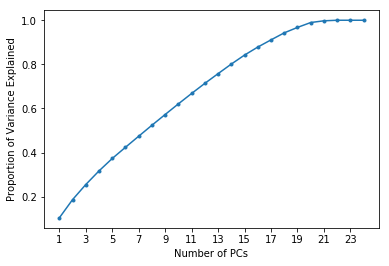

,cum_var
12,0.757964
13,0.801379
14,0.842192
15,0.878457
16,0.911047
17,0.942896


In [17]:
plt.figure()
plt.plot(range(1,25), burbank_var_cum, marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,25,2))
plt.show()

cumulative_df = pd.DataFrame({'cum_var': burbank_pca.explained_variance_ratio_.cumsum()})
#cumulative_df.sort_values(by=['cum_var'], ascending=False).head(10)

percent_df = cumulative_df[(cumulative_df['cum_var']>0.75) & (cumulative_df['cum_var']<.95)]
percent_df

In [18]:
# run logistic regression use 15 PCA components, and optimized penalty and C values

estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA(n_components=15)),
              ('lr', LogisticRegression(penalty='l1', C=1))]
pipeline = Pipeline(estimators)

pipeline.fit(X_train, y_train)
print(f'The accuracy score on the train set is: {pipeline.score(X_train, y_train)}')
print(f'The accuracy score on the validation set is: {pipeline.score(X_validation, y_validation)}')

The accuracy score on the train set is: 0.6430315789473684
The accuracy score on the validation set is: 0.6576041492387485


In [19]:
# review the precision and recall

y_pred = burbank_lr.predict(X_validation)
print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))

[[14594  1140]
 [ 7018  1156]]
              precision    recall  f1-score   support

           0       0.68      0.93      0.78     15734
           1       0.50      0.14      0.22      8174

    accuracy                           0.66     23908
   macro avg       0.59      0.53      0.50     23908
weighted avg       0.62      0.66      0.59     23908



In [20]:
coefficient_df = pd.DataFrame(columns=['Feature', 'Coefficient'])

coefficient_df['Feature'] = burbank2017_df.iloc[:, :-1].columns.T
coefficient_df['Coefficient'] = burbank_lr.coef_.T.reshape(24)

display(coefficient_df.sort_values(by = ['Coefficient'], ascending=False).head(10))
display(coefficient_df.sort_values(by = ['Coefficient']).head(10))

,Feature,Coefficient
1,CRSDepTime,0.268998
10,Dest_TEMP,0.123298
3,Origin_WIND,0.095221
15,da_LAS,0.087373
2,Distance,0.085593
16,da_OAK,0.081179
0,DayOfWeek,0.079602
7,Dest_WIND,0.061601
8,Dest_PRCP,0.055998
9,Dest_SNOW,0.035029


,Feature,Coefficient
22,da_SLC,-0.289326
14,da_JFK,-0.150218
17,da_PDX,-0.103326
13,da_DEN,-0.085467
21,da_SJC,-0.084524
12,Month,-0.072875
18,da_PHX,-0.026388
23,da_SMF,-0.024890
4,Origin_PRCP,-0.019439
6,Origin_TEMP,-0.019035


In [21]:
# read in the 2019 burbank csv

burbank2019_df = pd.read_csv('burbank2019.csv', index_col=0)
burbank2019_df

,DayOfWeek,CRSDepTime,DepDelay,Cancelled,Distance,CRSArrTime,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,B6,OO,UA,WN,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed
0,4,1405,6.0,0,937,1645,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,4,1710,6.0,0,817,1920,8.50,0.00,0.0,76.5,5.14,0.00,0.0,74.0,1,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,4,1925,-2.0,0,937,2205,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,4,800,-7.0,0,937,1040,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,4,1050,-1.0,0,937,1330,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28284,1,2107,-9.0,0,2465,521,6.71,0.00,0.0,72.5,11.41,0.46,0.0,40.0,18,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28285,1,1445,7.0,0,2465,2300,6.71,0.00,0.0,72.5,11.41,0.46,0.0,40.0,18,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
28286,2,2107,-11.0,0,2465,521,6.93,0.00,0.0,67.5,8.28,0.17,0.0,44.0,19,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28287,5,1435,13.0,0,2465,2250,8.28,0.00,0.0,48.0,16.55,0.00,0.0,37.0,29,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
# delete outliers (i.e. rows where the departure delays are greater than one hour)
# remove the Cancelled and DepDelay columns
# remove airline because totals are imbalanced, placing too much importance on WN
# remove CRSArrTime because most of the flights are in a local region, so arrivel and departure time are closely related

burbankdrop2019 = burbank2019_df['DepDelay'][(burbank2019_df['DepDelay'] > 60)].index
burbank2019_df.drop(burbankdrop2019, inplace=True)

burbank2019final_df = burbank2019_df.copy()

burbank2019final_df.drop(['Cancelled',
                          'DepDelay',
                          'CRSArrTime',
                          'B6',
                          'OO',
                          'UA',
                          'WN'], axis=1, inplace=True)
burbank2019final_df

,DayOfWeek,CRSDepTime,Distance,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed
0,4,1405,937,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,1,0,0,0,0,0
1,4,1710,817,8.50,0.00,0.0,76.5,5.14,0.00,0.0,74.0,1,8,0,0,0,0,1,0,0,0,0,0,0,0
2,4,1925,937,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,1,0,0,0,0,1
3,4,800,937,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,1,0,0,0,0,1
4,4,1050,937,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28284,1,2107,2465,6.71,0.00,0.0,72.5,11.41,0.46,0.0,40.0,18,11,0,1,0,0,0,0,0,0,0,0,0,0
28285,1,1445,2465,6.71,0.00,0.0,72.5,11.41,0.46,0.0,40.0,18,11,0,1,0,0,0,0,0,0,0,0,0,1
28286,2,2107,2465,6.93,0.00,0.0,67.5,8.28,0.17,0.0,44.0,19,11,0,1,0,0,0,0,0,0,0,0,0,0
28287,5,1435,2465,8.28,0.00,0.0,48.0,16.55,0.00,0.0,37.0,29,11,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
# split and scale the 2019 data

X_test = burbank2019final_df.iloc[:, :-1]
y_test = burbank2019final_df.iloc[:,-1]

X_test = scaler.transform(X_test)

In [24]:
# final test score

print(f'The accuracy score on the Logistic Regression test set is: {burbank_lr.score(X_test, y_test)}')

The accuracy score on the Logistic Regression test set is: 0.6971995983487671


In [25]:
# review the precision and recall

y_pred = burbank_lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[17811  1502]
 [ 6640   936]]
              precision    recall  f1-score   support

           0       0.73      0.92      0.81     19313
           1       0.38      0.12      0.19      7576

    accuracy                           0.70     26889
   macro avg       0.56      0.52      0.50     26889
weighted avg       0.63      0.70      0.64     26889



In [26]:
# create a dataframe for 2019 showing the actual and predicted flights that are delayed

comparison_df = pd.DataFrame()
comparison_df['actual'] = y_test
comparison_df['pred'] = y_pred
comparison_df.loc[comparison_df['actual'] == comparison_df['pred'], 'correct'] = 1
comparison_df.loc[comparison_df['actual'] != comparison_df['pred'], 'correct'] = 0
comparison_df

,actual,pred,correct
0,0,0,1.0
1,0,0,1.0
2,1,0,0.0
3,1,0,0.0
4,0,0,1.0
...,...,...,...
28284,0,0,1.0
28285,1,0,0.0
28286,0,0,1.0
28287,0,0,1.0


In [27]:
# check that the 'correct' column is accurate

print(comparison_df['correct'].sum())
print(comparison_df['correct'].count())
print(comparison_df['correct'].sum() / comparison_df['correct'].count())

18747.0
26889
0.6971995983487671


In [28]:
# check that the 'correct' column is accurate

print('Predicted delayed flights: ' + str(comparison_df['pred'].sum()))
print('Actual delayed flights: ' + str(comparison_df['actual'].sum()))

Predicted delayed flights: 2438
Actual delayed flights: 7576


In [29]:
# append the 'pred' and correct' columns to the 2019 Burbank dataframe

burbank2019_df['Pred'] = comparison_df['pred']
burbank2019_df['Correct'] = comparison_df['correct']
burbank2019_df['Correct'] = burbank2019_df['Correct'].astype(int)
burbank2019_df

,DayOfWeek,CRSDepTime,DepDelay,Cancelled,Distance,CRSArrTime,Origin_WIND,Origin_PRCP,Origin_SNOW,Origin_TEMP,Dest_WIND,Dest_PRCP,Dest_SNOW,Dest_TEMP,Day,Month,B6,OO,UA,WN,da_DEN,da_JFK,da_LAS,da_OAK,da_PDX,da_PHX,da_SEA,da_SFO,da_SJC,da_SLC,da_SMF,Delayed,Pred,Correct
0,4,1405,6.0,0,937,1645,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,4,1710,6.0,0,817,1920,8.50,0.00,0.0,76.5,5.14,0.00,0.0,74.0,1,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,4,1925,-2.0,0,937,2205,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,4,800,-7.0,0,937,1040,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,4,1050,-1.0,0,937,1330,8.50,0.00,0.0,76.5,7.83,0.00,0.0,71.0,1,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28284,1,2107,-9.0,0,2465,521,6.71,0.00,0.0,72.5,11.41,0.46,0.0,40.0,18,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
28285,1,1445,7.0,0,2465,2300,6.71,0.00,0.0,72.5,11.41,0.46,0.0,40.0,18,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
28286,2,2107,-11.0,0,2465,521,6.93,0.00,0.0,67.5,8.28,0.17,0.0,44.0,19,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
28287,5,1435,13.0,0,2465,2250,8.28,0.00,0.0,48.0,16.55,0.00,0.0,37.0,29,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
# check that the 'correct' column was properly appended to the Burbank dataframe

print(burbank2019_df['Correct'].sum())
print(burbank2019_df['Correct'].count())
print(burbank2019_df['Correct'].sum() / burbank2019_df['Correct'].count())

18747
26889
0.6971995983487671


In [31]:
# used to check against totals in Tableau to ensure accuracy

print('Delayed flights in 2017: ' + str(burbank2017_df['Delayed'].sum()))
print('Delayed flights in 2018: ' + str(burbank2018_df['Delayed'].sum()))
print('Delayed flights in 2019: ' + str(burbank2019_df['Delayed'].sum()))

Delayed flights in 2017: 8643
Delayed flights in 2018: 8174
Delayed flights in 2019: 7576


In [32]:
# export the final Burbank dataframe to a csv

burbank2019_df.to_csv('burbankfinal2019.csv')